# **Product Vision Search:** Build a Product recognition engine in one hour
This example is using a Kaggle dataset for product recognition. The goal is to extract a csv for bulk import in Product Vision Search  
**Useful links:**  
https://github.com/zinjiggle/google-product-search-simple-ui  
https://github.com/GoogleCloudPlatform/python-docs-samples/tree/master/vision/cloud-client/product_search

## 0. Install vision library

In [ ]:
pip install google-cloud-vision

In [2]:
project_id='pod-fr-retail'
location='europe-west1'
product_set='kaggle_shoes'
gcs_bucket="gs://pod-fr-retail-kaggle/"

In [3]:
from google.cloud import vision_v1

## 3.3 Check index time of product sets 

In [4]:
import time
from google.cloud import vision_v1
client = vision_v1.ProductSearchClient()
parent = client.location_path(project_id, location)
name = client.product_set_path(project_id, location, product_set)
for element in client.list_product_sets(parent):
    print(element)
    print('Last index:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(element.index_time.seconds)))
    print('------')
    pass
#print(client.list_products_in_product_set(name))


name: "projects/pod-fr-retail/locations/europe-west1/productSets/kaggle_shoes"
display_name: " "
index_time {
  seconds: 1665847261
  nanos: 540521018
}
index_error {
}

Last index: 2022-10-15 15:21:01
------
name: "projects/pod-fr-retail/locations/europe-west1/productSets/pvs_shoes"
display_name: " "
index_time {
  seconds: 1665847261
  nanos: 540521018
}
index_error {
}

Last index: 2022-10-15 15:21:01
------


In [8]:
from google.cloud import vision
from google.cloud import storage
from IPython.display import Image, display

def get_image(uri):
    client_storage = storage.Client() # Implicit environment set up
    bucket = uri.split("/")[2]
    object_name = "/".join(uri.split("/")[3:])
    # with explicit set up:
    # client = storage.Client.from_service_account_json('key-file-location')
    bucket = client_storage.get_bucket(bucket)
    blob = bucket.get_blob(object_name)
    return(Image(blob.download_as_bytes()))
    
def get_similar_products_file(
        project_id,
        location,
        product_set_id,
        product_category,
        file_path,
        filter,
        max_results
):
    """Search similar products to image.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_set_id: Id of the product set.
        product_category: Category of the product.
        file_path: Local file path of the image to be searched.
        filter: Condition to be applied on the labels.
                Example for filter: (color = red OR color = blue) AND style = kids
                It will search on all products with the following labels:
                color:red AND style:kids
                color:blue AND style:kids
        max_results: The maximum number of results (matches) to return. If omitted, all results are returned.
    """
    # product_search_client is needed only for its helper methods.
    product_search_client = vision.ProductSearchClient()
    image_annotator_client = vision.ImageAnnotatorClient()

    # Read the image as a stream of bytes.
    with open(file_path, 'rb') as image_file:
        content = image_file.read()

    # Create annotate image request along with product search feature.
    image = vision.types.image_annotator_pb2.Image(content=content)

    # product search specific parameters
    product_set_path = product_search_client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)
    product_search_params = vision.types.ProductSearchParams(
        product_set=product_set_path,
        product_categories=[product_category],
        filter=filter)
    image_context = vision.types.ImageContext(
        product_search_params=product_search_params)

    # Search products similar to the image.
    response = image_annotator_client.product_search(
        image,
        image_context=image_context,
        max_results=max_results
    )
    
    index_time = response.product_search_results.index_time
    print('Product set index time: ')
    print(index_time)

    results = response.product_search_results.results

    print('Search results:')
    i=0
    for result in results:
        print('--------------------Result ', i)
        image = product_search_client.get_reference_image(name=result.image)
        display(get_image(image.uri))
        product = result.product
        print('Score(Confidence): {}'.format(result.score))
        print('Image name: {}'.format(result.image))
        print('Product name: {}'.format(product.name))
        print('Product display name: {}'.format(
            product.display_name))
        print('Product description: {}\n'.format(product.description))
        print('Product labels: {}\n'.format(product.product_labels))
        i=i+1

Product set index time: 
seconds: 1665847261
nanos: 540521018

Search results:
--------------------Result  0


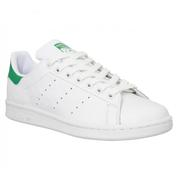

Score(Confidence): 0.7613340616226196
Image name: projects/pod-fr-retail/locations/europe-west1/products/12639984/referenceImages/1000010538-12639984-0
Product name: projects/pod-fr-retail/locations/europe-west1/products/12639984
Product display name: 12639984
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]

--------------------Result  1


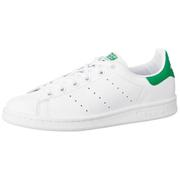

Score(Confidence): 0.7419224381446838
Image name: projects/pod-fr-retail/locations/europe-west1/products/20999212/referenceImages/1000010538-20999212-0
Product name: projects/pod-fr-retail/locations/europe-west1/products/20999212
Product display name: 20999212
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]

--------------------Result  2


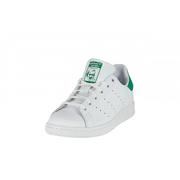

Score(Confidence): 0.7251256108283997
Image name: projects/pod-fr-retail/locations/europe-west1/products/3678282/referenceImages/1000010538-3678282-1
Product name: projects/pod-fr-retail/locations/europe-west1/products/3678282
Product display name: 3678282
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]

--------------------Result  3


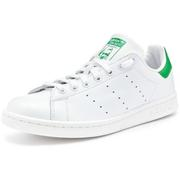

Score(Confidence): 0.7158138751983643
Image name: projects/pod-fr-retail/locations/europe-west1/products/17404193/referenceImages/1000010538-17404193-1
Product name: projects/pod-fr-retail/locations/europe-west1/products/17404193
Product display name: 17404193
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]

--------------------Result  4


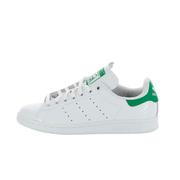

Score(Confidence): 0.7048333287239075
Image name: projects/pod-fr-retail/locations/europe-west1/products/10650683/referenceImages/1000010538-10650683-0
Product name: projects/pod-fr-retail/locations/europe-west1/products/10650683
Product display name: 10650683
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]

--------------------Result  5


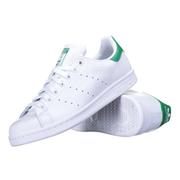

Score(Confidence): 0.7029097676277161
Image name: projects/pod-fr-retail/locations/europe-west1/products/9768449/referenceImages/1000010538-9768449-0
Product name: projects/pod-fr-retail/locations/europe-west1/products/9768449
Product display name: 9768449
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]

--------------------Result  6


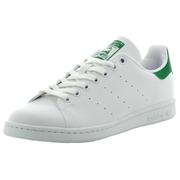

Score(Confidence): 0.6922504305839539
Image name: projects/pod-fr-retail/locations/europe-west1/products/8230732/referenceImages/1000010538-8230732-0
Product name: projects/pod-fr-retail/locations/europe-west1/products/8230732
Product display name: 8230732
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]

--------------------Result  7


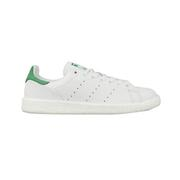

Score(Confidence): 0.6720495223999023
Image name: projects/pod-fr-retail/locations/europe-west1/products/10961372/referenceImages/1000010538-10961372-2
Product name: projects/pod-fr-retail/locations/europe-west1/products/10961372
Product display name: 10961372
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]

--------------------Result  8


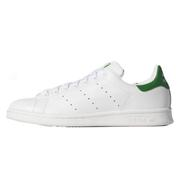

Score(Confidence): 0.6561815142631531
Image name: projects/pod-fr-retail/locations/europe-west1/products/9178755/referenceImages/1000010538-9178755-0
Product name: projects/pod-fr-retail/locations/europe-west1/products/9178755
Product display name: 9178755
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]

--------------------Result  9


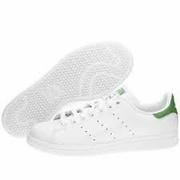

Score(Confidence): 0.65513014793396
Image name: projects/pod-fr-retail/locations/europe-west1/products/230518/referenceImages/1000010538-230518-1
Product name: projects/pod-fr-retail/locations/europe-west1/products/230518
Product display name: 230518
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]



In [9]:
get_similar_products_file(
        project_id,
        location,
        product_set,
        product_category="apparel-v2",
        file_path="adidas.jpeg",
        filter="",
        max_results=10
)